https://www.tensorflow.org/tutorials/text/image_captioning

https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import cv2
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
import tqdm

In [2]:
# Download caption annotation files.
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
    annotation_zip = tf.keras.utils.get_file('captions.zip', 
                                              cache_subdir=os.path.abspath('.'),
                                              origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                              extract=True)
    annotation_file = os.path.dirname(annotation_zip) + '/annotations/captions_train2014.json'
    os.remove(annotation_zip)
    annotation_file = os.path.dirname(annotation_zip) + '/annotations/captions_train2014.json'
    
else:
    annotation_file = os.path.abspath('.') + annotation_folder + 'captions_train2014.json'

# Read images

image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
    image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
    PATH = os.path.dirname(image_zip) + image_folder
    os.remove(image_zip)
else:
    PATH = os.path.abspath('.') + image_folder



In [3]:
# Optional to limit size of the training set.

with open(annotation_file, 'r') as f:
    annotations = json.load(f)
    
all_captions = []
all_img_name_vector = []

# annotations['annotations'] - list
# annotations - dict

for annot in annotations['annotations'][:500]:
    caption = '<start> ' + annot['caption'] + '<end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' %(image_id)

#     plt.figure(figsize=(12,12))
#     img = cv2.imread(full_coco_image_path)
#     plt.imshow(img)
#     plt.show()
    
    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)
    
train_captions, img_name_vector = shuffle(all_captions, all_img_name_vector, 
                                             random_state=1)
num_examples = 30000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]
print('Total captions in train set:', len(train_captions))
print('Total captions in the downloaded dataset:', len(all_captions))



Total captions in train set: 500
Total captions in the downloaded dataset: 500


In [4]:
# Preprocessing.

def load_image(image_path):
    # Read image in the image path.
    img = tf.io.read_file(image_path) 
    img = tf.image.decode_jpeg(img, channels=3)
    # Resize img 299,299 as per Inception V3 training details.
    img = tf.image.resize(img, (299,299))     
    # Normalize pixel values between -1 and 1 as per Inception v3 training details.
    img = tf.keras.applications.inception_v3.preprocess_input(img) 
    return img, image_path


In [5]:
# Initialize Inception V3 and load the pretrained ImageNet weights

image_model = tf.keras.applications.InceptionV3(include_top=False, # Whether to include the FCN at the last layer
                                               weights='imagenet') # Use pre-trained imagenet weights.
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
# print('Model:\n',image_model.summary())
print('Hidden layer:\n', hidden_layer.shape)
print('Input:\n', new_input)
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)



Hidden layer:
 (None, None, None, 2048)
Input:
 Tensor("input_1:0", shape=(None, None, None, 3), dtype=float32)


In [6]:
# Get unique images.
encode_train = sorted(set(img_name_vector))

# batch_size fixed depending on the system configuration.
# Source data from the input data. 
# Iteration happens in a streaming manner and 
# dataset is not fit in the memeory.
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
    load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm.tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
#     print('Batch features extracted:',batch_features.shape)
    batch_features = tf.reshape(batch_features,
                                (batch_features.shape[0], -1, batch_features.shape[3]))
#     print('Reshaped batch features:',batch_features.shape)
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode('utf-8')
        np.save(path_of_feature, bf.numpy())


10it [00:15,  1.51s/it]


In [7]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [8]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                 oov_token="<unk>",
                                                 filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
# print(tokenizer.word_counts) # OrderedDict of word and count
# print(tokenizer.document_count) # Number of captions
# print(tokenizer.word_index) # Dict of word and respective index value encoded
# print(tokenizer.word_docs)
train_seqs = tokenizer.texts_to_sequences(train_captions)


In [9]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [10]:
# Create tokenized vectors.
train_seqs = tokenizer.texts_to_sequences(train_captions)
# for i in train_seqs:
#     print(len(i))

In [11]:
# Pad each vector to the max_length of the captions.
# Since max length is not given pad_sequences calculates automatically.
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(
    train_seqs, padding='post')
print(cap_vector.shape)

(500, 20)


In [12]:
# This max_length is used to store the attention weights.
max_length = calc_max_length(train_seqs)
print(max_length)

20


In [13]:
# Split training and testing data.
# Create training and validation sets using 80-20 split.
# image file name for training and validation
# caption for training and validation
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector, 
                                                                    test_size=0.2, 
                                                                    random_state=0)
print(len(img_name_train), len(cap_train), len(img_name_val), len(cap_val))

400 400 100 100


In [14]:
# Create tf.data dataset for training

# Tunable parameters depending on the system's configuration.
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE

# Shape of the vector extracted from InceptionV3 is (64, 2048).
# It represent the vector shape.
feature_shape = 2048
attention_features_shape = 64

In [16]:
# Load the numpy files.
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

In [17]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
    map_func, [item1, item2], [tf.float32, tf.int32]),
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [18]:
# Model

class BahdanauAttention(tf.keras.Model):
    '''
    Bahdanau Attention. Main paper: https://arxiv.org/pdf/1409.0473.pdf
    Neural Machine Translation by Jointly Learning to Align and Translate.
    
    Useful material for Bahdanau Attention: https://blog.floydhub.com/attention-mechanism/
    
    Based on the paper: https://arxiv.org/abs/1406.1078v1
    Learning Phrase Representations using RNN Encoder–Decoder
    for Statistical Machine Translation.
    '''
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
    
    def call(self, features, hidden):
        # features(CNN_encoder, input) shape == (batch_size, 64, embedding_dim)
        
        # hidden_shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        # score_shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, 64, 1)
        # you get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features # context_vector shape: (bs, 64, 256)
        context_vector = tf.reduce_sum(context_vector, axis=1) # context_vector shape: (bs, 256)
        
        return context_vector, attention_weights
        

In [19]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle.
    # This encoder passes those features through a fully connected layer.
    
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)
    def call(self, x):
        x = self.fc(x) # x input shape: (bs, 64, 2048)
        x = tf.nn.relu(x) # x output shape: (bs, 64, 256)
        return x        

In [20]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units, # Dimension of output space.
                                      return_sequences=True, # whether to return the last output in the output sequence or full sequence.
                                      return_state=True, # whether to return the last state in addition to the output.
                                      recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        
        self.attention = BahdanauAttention(self.units)
    
    def call(self, x, features, hidden):
        
        # (x, features, hidden) shape = (bs, 1) (bs, 64, embedding_size) (bs, units)        
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)
        # context_vector shape: (bs, 256)
        # attention_weights shape: (bs, 64, 1)
        
        # x shape before embedding == (batch_size, 1) 
        # 1 is the previous word index value.
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x) # x shape: (bs, 1, 256)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector,1), x], axis=-1) # x shape: (bs, 1, 512)
        
        # passing the concatenated vector to the GRU
        # output shape == (bs, 1, 512)
        # state shape == (bs, 512)
        output, state = self.gru(x)
        
        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output) # x shape: (bs, 1, 512)
        
        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2])) # x shape: (bs, 512)
        
        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x) # x shape: (bs, 5001)
        
        return x, state, attention_weights
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))
        

In [21]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size) # (256, 512, 5001)

In [22]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [23]:
checkpoint_path = './checkpoints/train'
ckpt = tf.train.Checkpoint(encoder=encoder,
                          decoder=decoder,
                          optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [24]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [25]:
loss_plot = []

In [26]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    # initializing the hidden state for each batch
    # because the captions are not related from image to image.

    hidden = decoder.reset_state(batch_size=target.shape[0]) # shape: (bs, 512)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1) # shape: (bs,1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor) # features shape: (bs, 64, 256)
        
        for i in range(1, target.shape[1]):
            # passing the features through the decoder.
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            
            loss += loss_function(target[:, i], predictions)
            
            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)
            
    total_loss = (loss/ int(target.shape[1]))
    
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    
    gradients = tape.gradient(loss, trainable_variables)
    
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    
    return loss, total_loss

In [ ]:
EPOCHS = 25

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'. format(
            epoch + 1, batch, batch_loss.numpy()/int(target.shape[1])))
            
    # storing the epoch end loss value to plot later.
    loss_plot.append(total_loss/ num_steps)
    
    if epoch % 5 == 0:
        ckpt_manager.save()
        
    print('Epoch {} Loss {:.6f}'. format(epoch + 1, total_loss/num_steps))
    print('Time taken for 1 epoch {} second \n'. format(time.time() - start))

Epoch 1 Batch 0 Loss 2.4419
Epoch 1 Loss 2.842076
Time taken for 1 epoch 31.558382034301758 second 

Epoch 2 Batch 0 Loss 2.3727


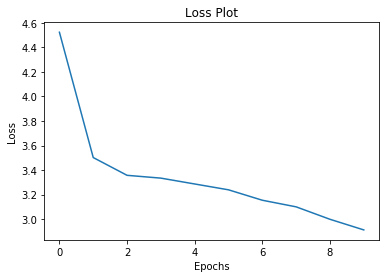

In [28]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [45]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))
    hidden = decoder.reset_state(batch_size=1)
    
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    
    features = encoder(img_tensor_val)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []
    
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        
        predicted_id = tf.random.categorical(predictions, 1)[0][0]
        result.append(tokenizer.index_word[predicted_id.numpy()])
        
        
        if tokenizer.index_word[predicted_id.numpy()] == '<end>':
            return result, attention_plot
        
        dec_input = tf.expand_dims([predicted_id.numpy()], 0)
        
    attention_plot = attention_plot[:len(result), :]
    
    return result, attention_plot

In [50]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))
    
    fig = plt.figure(figsize=(10,10))
    
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8,8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())
    
    plt.tight_layout()
    plt.show()
    

Real caption: <start> two children sitting down one with his arm over the other <end>
Prediction caption: a gate their <end>


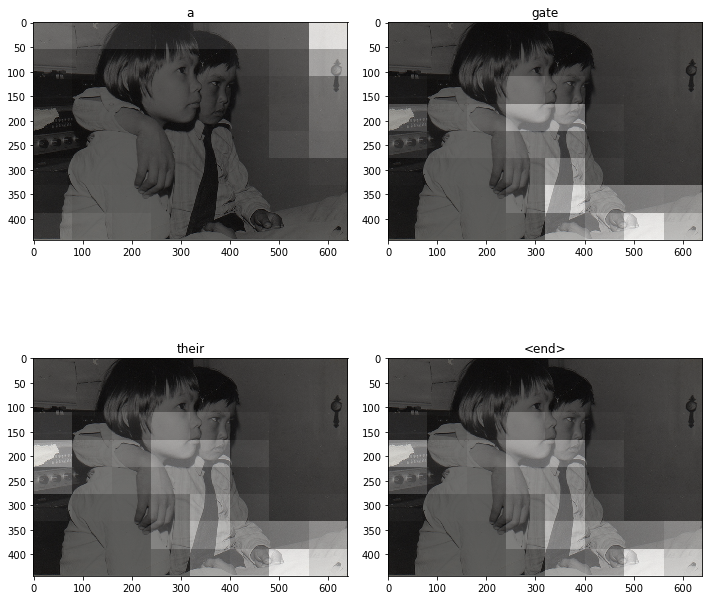

In [51]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real caption:', real_caption)
print('Prediction caption:', ' '.join(result))
plot_attention(image, result, attention_plot)